#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=5f26a920-c858-4628-8ebc-cd6a7ecd8bc9
To: /home/jupyter/week6/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 111MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [5]:
spikes_val.shape

(288, 168)

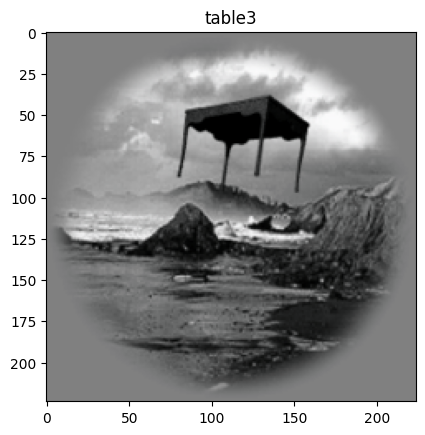

In [6]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

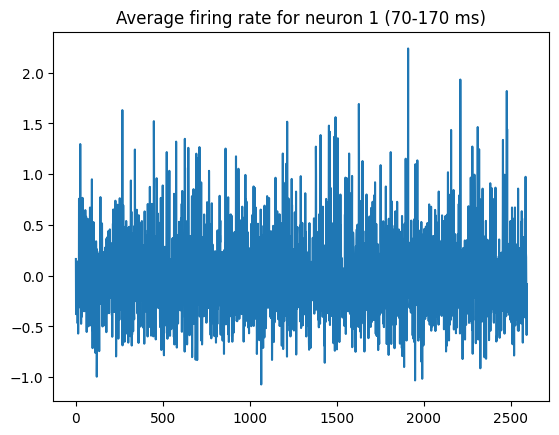

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [8]:
#### Prepare the data
# Flatten the images 

X_train = stimulus_train.reshape(n_stimulus, -1)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
X_test = stimulus_test.reshape(stimulus_test.shape[0], -1)


Y_train = spikes_train
Y_val = spikes_val

In [9]:
X_val.shape

(288, 150528)

In [10]:
# Using least square
from sklearn.linear_model import LinearRegression

# Initialize and fit the OLS model
model_ls = LinearRegression()
model_ls.fit(X_train, Y_train)

# Predictions
Y_pred_train_ls = model_ls.predict(X_train)
Y_pred_val_ls = model_ls.predict(X_val)

In [11]:
Y_pred_val_ls.shape

(288, 168)

In [12]:
# using ridge regression

from sklearn.linear_model import Ridge

# Initialize and fit the Ridge model
# You might want to use cross-validation to find the best alpha
model_r = Ridge(alpha=1.0)
model_r.fit(X_train, Y_train)

# Predictions
Y_pred_train_r = model_r.predict(X_train)
Y_pred_val_r = model_r.predict(X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.02974e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

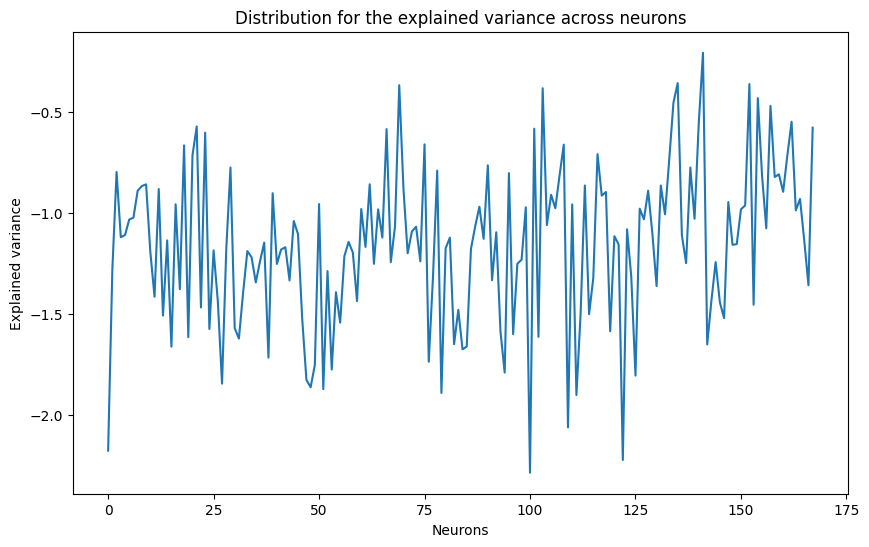

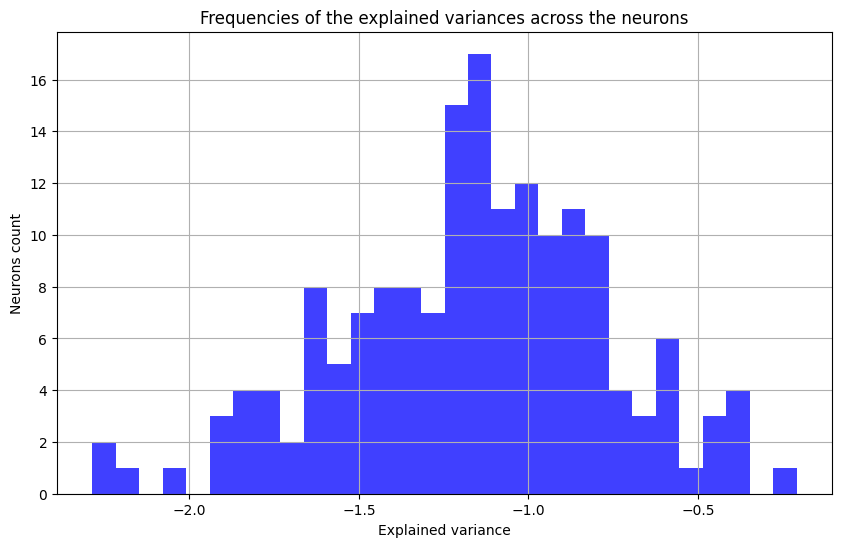

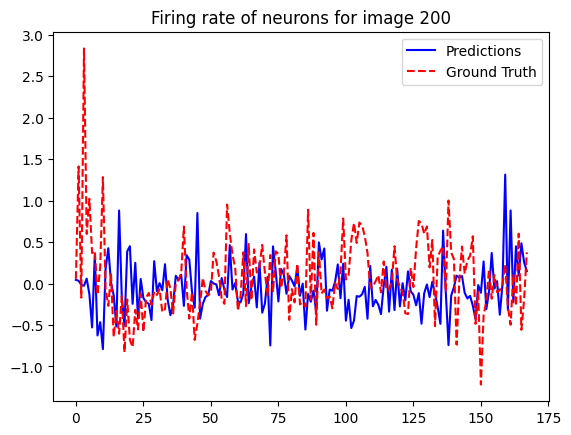

In [13]:
# Explained variance
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
\
explained_variances_ls = [explained_variance_score(Y_val[:, i], Y_pred_val_ls[:, i]) for i in range(Y_val.shape[1])]
explained_variances_r = [explained_variance_score(Y_val[:, i], Y_pred_val_r[:, i]) for i in range(Y_val.shape[1])]


plt.figure(figsize=(10, 6))
plt.plot(explained_variances_ls)
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(explained_variances_ls, bins=30, alpha=0.75, color='blue')
plt.title('Frequencies of the explained variances across the neurons')
plt.xlabel('Explained variance')
plt.ylabel('Neurons count')
plt.grid(True)
plt.show()

img_idx = 200

plt.figure()
plt.title(f'Firing rate of neurons for image {img_idx}')
plt.plot(Y_pred_train_ls[img_idx, :], color='blue', label='Predictions')
plt.plot(Y_val[img_idx, :], color='red', linestyle='--', label='Ground Truth')
plt.legend()
plt.show()

In [14]:
# Correlation, using numpy
import numpy as np

correlations_ls = [np.corrcoef(Y_val[:, i], Y_pred_val_ls[:, i])[0, 1] for i in range(Y_val.shape[1])]
correlations_r = [np.corrcoef(Y_val[:, i], Y_pred_val_r[:, i])[0, 1] for i in range(Y_val.shape[1])]

In [15]:
print('Explained variance, least square: ', np.mean(explained_variances_ls))
print('Explained variance, ridge regression: ', np.mean(explained_variances_r))

print('Pearson correlation, least square: ', np.mean(correlations_ls))
print('Pearson correlation, ridge regression: ', np.mean(correlations_r))

Explained variance, least square:  -1.1615342852615176
Explained variance, ridge regression:  -1.15740371743838
Pearson correlation, least square:  0.14653536965677535
Pearson correlation, ridge regression:  0.14668567081874873


##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [16]:
#### Fit the pca
from sklearn.decomposition import PCA

pca = PCA(n_components = 1000)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [17]:
print(X_val_pca.shape)
print(X_val.shape)

(288, 1000)
(288, 150528)


In [18]:
## make the predictions with least square
model_pca_ls = LinearRegression()
model_pca_ls.fit(X_train_pca, Y_train)

Y_val_pca_pred_ls = model_pca_ls.predict(X_val_pca)

In [19]:
## make the predictions with ridge
model_pca_r = Ridge(alpha=1.0)
model_pca_r.fit(X_train_pca, Y_train)

Y_val_pca_pred_r = model_pca_r.predict(X_val_pca)

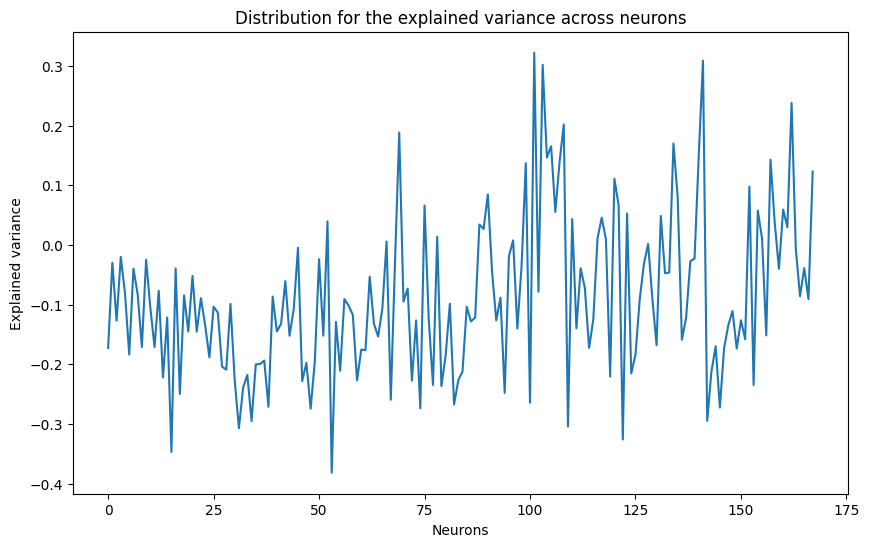

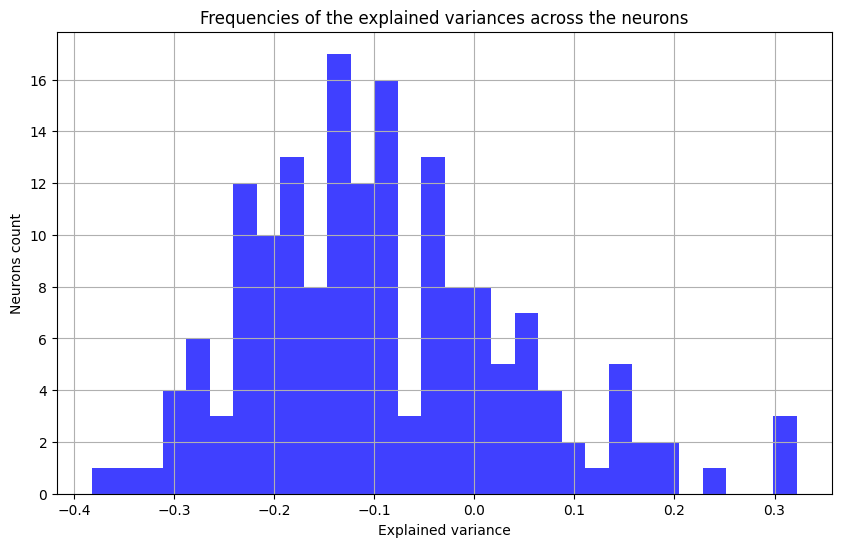

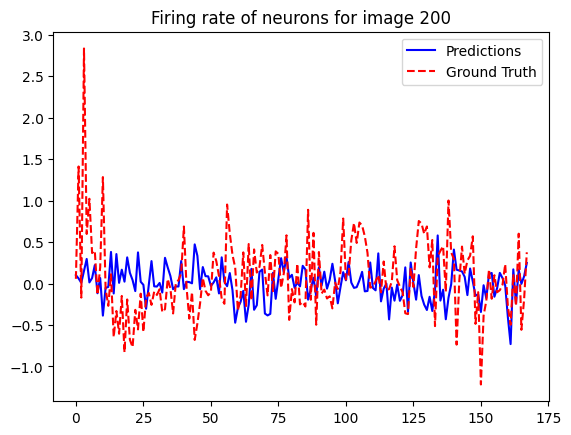

In [20]:
# Explained variance
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

correlations_pca_ls = [np.corrcoef(Y_val[:, i], Y_val_pca_pred_ls[:, i])[0, 1] for i in range(Y_val.shape[1])]
correlations_pca_r = [np.corrcoef(Y_val[:, i], Y_val_pca_pred_r[:, i])[0, 1] for i in range(Y_val.shape[1])]

explained_variances_pca_ls = [explained_variance_score(Y_val[:, i], Y_val_pca_pred_ls[:, i]) for i in range(Y_val.shape[1])]
explained_variances_pca_r = [explained_variance_score(Y_val[:, i], Y_val_pca_pred_r[:, i]) for i in range(Y_val.shape[1])]


plt.figure(figsize=(10, 6))
plt.plot(explained_variances_pca_ls)
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(explained_variances_pca_ls, bins=30, alpha=0.75, color='blue')
plt.title('Frequencies of the explained variances across the neurons')
plt.xlabel('Explained variance')
plt.ylabel('Neurons count')
plt.grid(True)
plt.show()

img_idx = 200

plt.figure()
plt.title(f'Firing rate of neurons for image {img_idx}')
plt.plot(Y_val_pca_pred_ls[img_idx, :], color='blue', label='Predictions')
plt.plot(Y_val[img_idx, :], color='red', linestyle='--', label='Ground Truth')
plt.legend()
plt.show()

In [21]:
print('Explained variance, 1000 pcs least square: ', np.mean(explained_variances_pca_ls))
print('Explained variance, 1000 pcs ridge regression: ', np.mean(explained_variances_pca_r))

print('Pearson correlation, 1000 pcs least square: ', np.mean(correlations_pca_ls))
print('Pearson correlation, 1000 pcs regression: ', np.mean(correlations_pca_r))

Explained variance, 1000 pcs least square:  -0.08989357132287253
Explained variance, 1000 pcs ridge regression:  -0.08987385886056083
Pearson correlation, 1000 pcs least square:  0.21264608392193068
Pearson correlation, 1000 pcs regression:  0.21264999594063433


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [21]:
#### NO NEED TO RUN!!!!
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

alphas = np.logspace(-6, 6, 50)
kf = KFold(n_splits=4, shuffle=True, random_state=1)



In [22]:
#### NO NEED TO RUN!!!!

model_r_cv = RidgeCV(alphas=alphas, cv=kf, scoring='neg_mean_squared_error')
model_r_cv.fit(X_train_pca, Y_train)
print("Best alpha:", model_r_cv.alpha_)


Best alpha: 323745.754281764


In [22]:
#alpha = 346924.9624812406
opt_model = Ridge(alpha = 323745.754281764)
opt_model.fit(X_train_pca, Y_train)

Y_val_opt = opt_model.predict(X_val_pca)

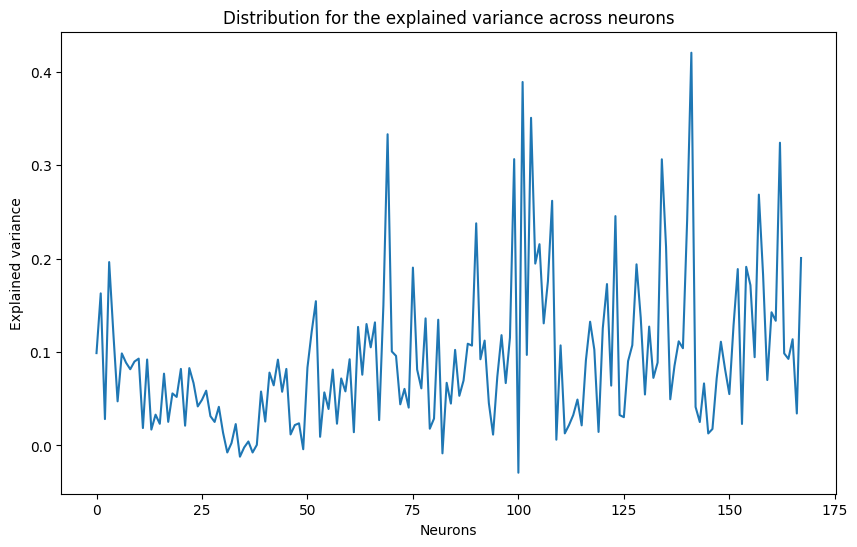

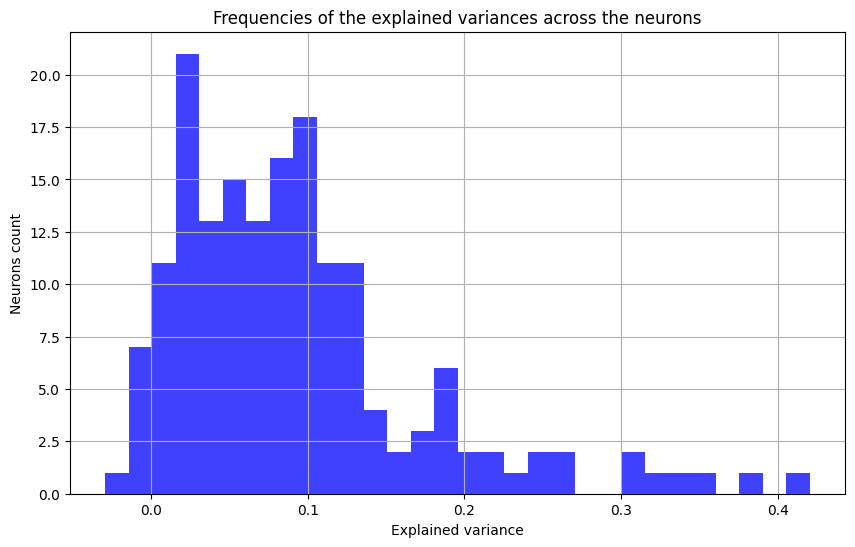

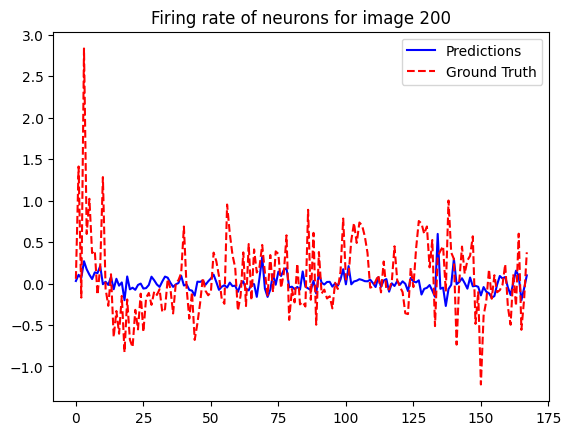

In [23]:
correlations_opt = [np.corrcoef(Y_val[:, i], Y_val_opt[:, i])[0, 1] for i in range(Y_val.shape[1])]

explained_variances_opt = [explained_variance_score(Y_val[:, i], Y_val_opt[:, i]) for i in range(Y_val.shape[1])]

plt.figure(figsize=(10, 6))
plt.plot(explained_variances_opt)
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(explained_variances_opt, bins=30, alpha=0.75, color='blue')
plt.title('Frequencies of the explained variances across the neurons')
plt.xlabel('Explained variance')
plt.ylabel('Neurons count')
plt.grid(True)
plt.show()

img_idx = 200

plt.figure()
plt.title(f'Firing rate of neurons for image {img_idx}')
plt.plot(Y_val_opt[img_idx, :], color='blue', label='Predictions')
plt.plot(Y_val[img_idx, :], color='red', linestyle='--', label='Ground Truth')
plt.legend()
plt.show()

In [24]:
print('Explained variance, optimized model: ', np.mean(explained_variances_opt))
print('Pearson correlation, optimal model: ', np.mean(correlations_opt))

Explained variance, optimized model:  0.09236095171599161
Pearson correlation, optimal model:  0.2845264564591668


In [25]:
# clean the memory
Y_val_opt = []
explained_variances_opt = []
explained_variances_pca_ls = []
explained_variances_pca_r = []
X_train_pca = []
model_pca_ls = []
Y_val_pca_pred_ls = []
model_pca_r = []
Y_val_pca_pred_r = []
explained_variances_pca_ls = []
explained_variances_pca_r = []
opt_model = []
Y_val_opt = []
explained_variances_opt = []

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [26]:
#### Load the model

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets

model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
from torch.utils.data import DataLoader, TensorDataset
import torch

X_train = torch.tensor(stimulus_train, dtype=torch.float32)
Y_train = torch.tensor(spikes_train, dtype=torch.float32)
X_val = torch.tensor(stimulus_val, dtype=torch.float32)
Y_val = torch.tensor(spikes_val, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)

train_dataloader = DataLoader(train_ds, batch_size=48, shuffle=False)
validation_dataloader = DataLoader(train_ds, batch_size=1000, shuffle=False)

## Layer: conv1

In [28]:
import torch
from torchvision.models import resnet50
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.decomposition import IncrementalPCA
import numpy as np

conv1_activation = []
conv1_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    conv1_activation.append(activation['conv1'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1 val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    conv1_activation_val.append(activation['conv1 val'].cpu().numpy())

In [29]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(conv1_activation, axis=0)
conv1_activation = []
activations_np = activations_np.reshape(2592, -1)
conv1_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [30]:
conv1_pcs.shape

(2592, 1000)

In [31]:
activations_np_val = np.concatenate(conv1_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
conv1_pcs_val = pca.transform(activations_np_val)
conv1_pcs_val.shape

(288, 1000)

In [32]:
conv1_activation_val = []
activations_np_val = []

In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

all_predictions = []

opt_model = Ridge(alpha = 1)
opt_model.fit(conv1_pcs, spikes_train)

Y_val_pred_conv1 = opt_model.predict(conv1_pcs_val)
all_predictions.append(Y_val_pred_conv1)

'''
alphas = np.logspace(-2, 2, 50)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Addestra il modello
ridge_cv.fit(conv1_pcs, Y_train)
best_alpha = ridge_cv.alpha_
print("Miglior valore di alpha trovato:", best_alpha)
'''

'\nalphas = np.logspace(-2, 2, 50)\nridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)\n\n# Addestra il modello\nridge_cv.fit(conv1_pcs, Y_train)\nbest_alpha = ridge_cv.alpha_\nprint("Miglior valore di alpha trovato:", best_alpha)\n'

In [34]:
Y_val_pred_conv1.shape

(288, 168)

## Layer: layer1

In [30]:
model.named_children

<bound method Module.named_children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

In [35]:
layer1_activation = []
layer1_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer1_activation.append(activation['layer1'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('layer1 val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer1_activation_val.append(activation['layer1 val'].cpu().numpy())

In [36]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(layer1_activation, axis=0)
layer1_activation = []
activations_np = activations_np.reshape(2592, -1)
layer1_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [37]:
activations_np_val = np.concatenate(layer1_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
layer1_pcs_val = pca.transform(activations_np_val)
layer1_pcs_val.shape

(288, 1000)

In [38]:
layer1_activation_val = []
activations_np_val = []

In [39]:
opt_model = Ridge(alpha = 1)
opt_model.fit(layer1_pcs, spikes_train)

Y_val_pred_layer1 = opt_model.predict(layer1_pcs_val)
all_predictions.append(Y_val_pred_layer1)

## Layer: layer2

In [43]:
layer2_activation = []
layer2_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer2.register_forward_hook(get_activation('layer2'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer2_activation.append(activation['layer2'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer2.register_forward_hook(get_activation('layer2 val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer2_activation_val.append(activation['layer2 val'].cpu().numpy())

In [44]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(layer2_activation, axis=0)
layer2_activation = []
activations_np = activations_np.reshape(2592, -1)
layer2_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [45]:
activations_np_val = np.concatenate(layer2_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
layer2_pcs_val = pca.transform(activations_np_val)
layer2_pcs_val.shape

(288, 1000)

In [46]:
layer2_activation_val = []
activations_np_val = []

In [47]:
opt_model = Ridge(alpha = 1)
opt_model.fit(layer2_pcs, spikes_train)

Y_val_pred_layer2 = opt_model.predict(layer2_pcs_val)
all_predictions.append(Y_val_pred_layer2)

## Layer: layer3

In [48]:
layer3_activation = []
layer3_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer3.register_forward_hook(get_activation('layer3'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer3_activation.append(activation['layer3'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer3.register_forward_hook(get_activation('layer3 val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer3_activation_val.append(activation['layer3 val'].cpu().numpy())

In [49]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(layer3_activation, axis=0)
layer3_activation = []
activations_np = activations_np.reshape(2592, -1)
layer3_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [50]:
activations_np_val = np.concatenate(layer3_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
layer3_pcs_val = pca.transform(activations_np_val)
layer3_pcs_val.shape

(288, 1000)

In [51]:
layer3_activation_val = []
activations_np_val = []

In [52]:
opt_model = Ridge(alpha = 1)
opt_model.fit(layer3_pcs, spikes_train)

Y_val_pred_layer3 = opt_model.predict(layer3_pcs_val)
all_predictions.append(Y_val_pred_layer3)

## Layer: layer4

In [53]:
layer4_activation = []
layer4_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer4.register_forward_hook(get_activation('layer4'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer4_activation.append(activation['layer4'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer4.register_forward_hook(get_activation('layer4 val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    layer4_activation_val.append(activation['layer4 val'].cpu().numpy())

In [54]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(layer4_activation, axis=0)
layer4_activation = []
activations_np = activations_np.reshape(2592, -1)
layer4_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [55]:
activations_np_val = np.concatenate(layer4_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
layer4_pcs_val = pca.transform(activations_np_val)
layer4_pcs_val.shape

(288, 1000)

In [56]:
layer4_activation_val = []
activations_np_val = []

In [57]:
opt_model = Ridge(alpha = 1)
opt_model.fit(layer4_pcs, spikes_train)

Y_val_pred_layer4 = opt_model.predict(layer4_pcs_val)
all_predictions.append(Y_val_pred_layer4)

## Layer: avgpool

In [58]:
avgpool_activation = []
avgpool_activation_val = []

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.avgpool.register_forward_hook(get_activation('avgpool'))

for i in X_train:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    avgpool_activation.append(activation['avgpool'].cpu().numpy())

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.avgpool.register_forward_hook(get_activation('avgpool val'))

for i in X_val:
    input_arg = i.unsqueeze(0)

    if torch.cuda.is_available():
        input_arg = input_arg.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_arg)

    avgpool_activation_val.append(activation['avgpool val'].cpu().numpy())

In [59]:
# compute the first 1000 pcs

pca = PCA(n_components=1000)

#activations_reshaped = activations.view(2592, -1)
activations_np = np.concatenate(avgpool_activation, axis=0)
avgpool_activation = []
activations_np = activations_np.reshape(2592, -1)
avgpool_pcs = pca.fit_transform(activations_np)
activations_np = []
activation = {}

In [60]:
activations_np_val = np.concatenate(avgpool_activation_val, axis=0)
activations_np_val = activations_np_val.reshape(288, -1)
avgpool_pcs_val = pca.transform(activations_np_val)
avgpool_pcs_val.shape

(288, 1000)

In [61]:
avgpool_activation_val = []
activations_np_val = []

In [62]:
opt_model = Ridge(alpha = 1)
opt_model.fit(avgpool_pcs, spikes_train)

Y_val_pred_avgpool = opt_model.predict(avgpool_pcs_val)
all_predictions.append(Y_val_pred_avgpool)

## Evaluation

In [63]:
all_predictions = np.array(all_predictions)

all_variances = []
all_correlations = []

for j in range(6):
    pred = all_predictions[j,:,:]
    explained_variances = [explained_variance_score(Y_val[:, i], pred[:, i]) for i in range(Y_val.shape[1])]
    correlations = [np.corrcoef(Y_val[:, i], pred[:, i])[0, 1] for i in range(Y_val.shape[1])]
    
    all_variances.append(explained_variances)
    
    all_correlations.append(correlations)
    
all_variances = np.array(all_variances)
all_correlations = np.array(all_correlations)

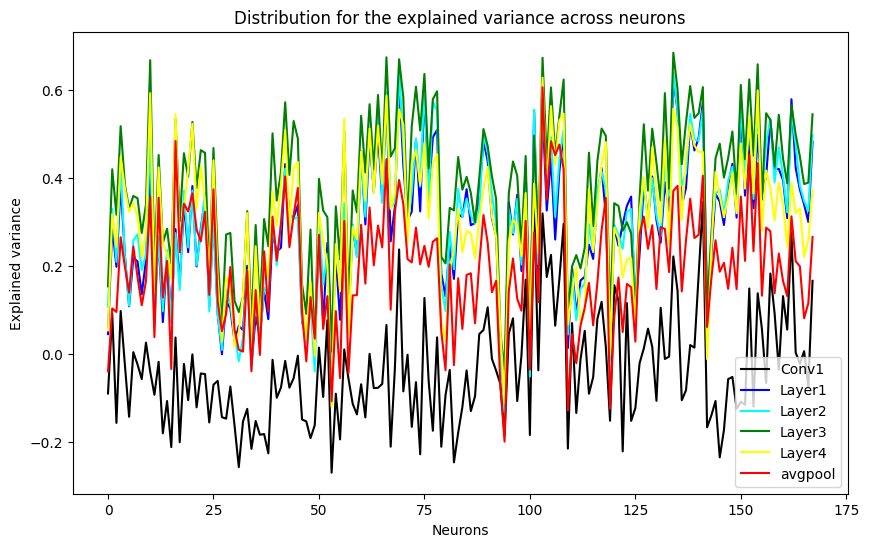

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(all_variances[0,:], color='black', label='Conv1')
plt.plot(all_variances[1,:], color='blue', label='Layer1')
plt.plot(all_variances[2,:], color='cyan', label='Layer2')
plt.plot(all_variances[3,:], color='green', label='Layer3')
plt.plot(all_variances[4,:], color='yellow', label='Layer4')
plt.plot(all_variances[5,:], color='red', label='avgpool')
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.legend()
plt.show()

In [65]:
print('Explained variance, conv1: ', np.mean(all_variances[0,:]))
print('Explained variance, layer1: ', np.mean(all_variances[1,:]))
print('Explained variance, layer2: ', np.mean(all_variances[2,:]))
print('Explained variance, layer3: ', np.mean(all_variances[3,:]))
print('Explained variance, layer4: ', np.mean(all_variances[4,:]))
print('Explained variance, avgpool: ', np.mean(all_variances[5,:]))

print('Pearson correlation, conv1: ', np.mean(all_correlations[0,:]))
print('Pearson correlation, layer1: ', np.mean(all_correlations[1,:]))
print('Pearson correlation, layer2: ', np.mean(all_correlations[2,:]))
print('Pearson correlation, layer3: ', np.mean(all_correlations[3,:]))
print('Pearson correlation, layer4: ', np.mean(all_correlations[4,:]))
print('Pearson correlation, avgpool: ', np.mean(all_correlations[5,:]))

Explained variance, conv1:  -0.037539870611258915
Explained variance, layer1:  0.2885316220067796
Explained variance, layer2:  0.3012952453323773
Explained variance, layer3:  0.3859506593573661
Explained variance, layer4:  0.3073305217992692
Explained variance, avgpool:  0.19371678751139415
Pearson correlation, conv1:  0.2319491584529623
Pearson correlation, layer1:  0.5251231791592954
Pearson correlation, layer2:  0.5367581015229755
Pearson correlation, layer3:  0.6103144974435596
Pearson correlation, layer4:  0.5496570497865811
Pearson correlation, avgpool:  0.4546269393907235
